In [1]:
import numpy as np
import pandas as pd
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt

from src.statistics.stats import compare_score, corrected_ci

In [2]:
df = pd.read_csv("../results/radiomics/rkf_results/light.csv")
# df = pd.read_csv("../results/radiomics/rkf_results/default.csv")
df_combat = pd.read_csv("../results/radiomics/rkf_results/light_combat.csv")
df_fusion = pd.read_csv("../results/radiomics/rkf_results/light_fusion.csv")
df_dummy = pd.read_csv("../results/radiomics/rkf_results/dummy.csv")
df_suvmax = pd.read_csv("../results/radiomics/rkf_results/suvmax.csv")
df_size = pd.read_csv("../results/radiomics/rkf_results/light_fusion_size_analysis.csv")

In [3]:
df_plot = df_size[df_size["voi"]=="GTV_L"]
df_plot["1/n_train"] = df_plot["n_train"].map(lambda x: 1/x)

/home/valentin/python_wkspce/plc_segmentation/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
df_plot.groupby("1/n_train").mean()

,Unnamed: 0,accuracy,n_test,n_train,npv,precision,roc_auc,sensitivity,specificity,split
1/n_train,,,,,,,,,,
0.011111,749.5,0.623727,10.6,90.0,0.571619,0.667448,0.605077,0.735238,0.4575,49.5
0.012500,649.5,0.600636,10.6,80.0,0.533095,0.652361,0.585583,0.700238,0.4540,49.5
0.014286,549.5,0.590818,10.6,70.0,0.510194,0.659209,0.582929,0.668810,0.4725,49.5
0.016667,449.5,0.592727,10.6,60.0,0.506274,0.655368,0.596679,0.680000,0.4640,49.5
0.020000,349.5,0.596455,10.6,50.0,0.499917,0.661548,0.594679,0.677143,0.4855,49.5
0.025000,249.5,0.546000,10.6,40.0,0.461821,0.611607,0.548923,0.605000,0.4650,49.5
0.033333,149.5,0.568182,10.6,30.0,0.490905,0.641234,0.545792,0.617619,0.4900,49.5
0.050000,49.5,0.534818,10.6,20.0,0.440694,0.617206,0.540286,0.591429,0.4535,49.5


In [5]:
linear_model = np.polyfit(df_plot["1/n_train"].values,
                          df_plot["roc_auc"].values, 1)
linear_model_fn = np.poly1d(linear_model)


In [6]:
linear_model_fn(1/10)

0.4465388836650761

In [7]:
linear_model

array([-1.66525696,  0.61306458])

<AxesSubplot:xlabel='1/n_train', ylabel='roc_auc'>

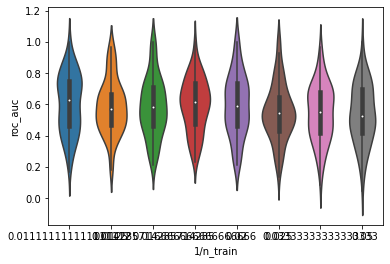

In [8]:
sns.violinplot(x="1/n_train", y="roc_auc", data=df_plot)

In [9]:
df_fcounts = pd.read_csv("../results/radiomics/rkf_results/light_feature_counts.csv")

In [10]:
df_f_hist = df_fcounts[(df_fcounts["modality"] == "PT")
                       & (df_fcounts["voi"] == "GTV_L") &
                       (df_fcounts["feature_count"] != 0.0)].sort_values(
                           by="feature_count")
df_f_hist.drop(["Unnamed: 0"], axis=1)

,feature_name,feature_count,modality,voi
421,log-sigma-5-0-mm-3D_firstorder_Minimum,1.0,PT,GTV_L
439,original_glcm_Correlation,1.0,PT,GTV_L
442,original_glcm_DifferenceVariance,5.0,PT,GTV_L
419,log-sigma-5-0-mm-3D_firstorder_Maximum,6.0,PT,GTV_L
424,log-sigma-5-0-mm-3D_firstorder_Variance,9.0,PT,GTV_L
422,log-sigma-5-0-mm-3D_firstorder_RobustMeanAbsol...,16.0,PT,GTV_L
430,original_firstorder_Minimum,32.0,PT,GTV_L
428,original_firstorder_Maximum,38.0,PT,GTV_L
454,original_glcm_SumEntropy,100.0,PT,GTV_L


In [11]:
df[(df["modality"] == "CT") & (df["voi"] == "GTV_L")].mean()

Unnamed: 0     149.500000
accuracy         0.750909
n_test          10.500000
n_train         94.500000
npv              0.734119
precision        0.783868
roc_auc          0.819940
sensitivity      0.827619
specificity      0.630500
split           49.500000
dtype: float64

In [12]:
df[(df["modality"] == "PET/CT") & (df["voi"] == "GTV_L")].mean()

Unnamed: 0    NaN
accuracy      NaN
n_test        NaN
n_train       NaN
npv           NaN
precision     NaN
roc_auc       NaN
sensitivity   NaN
specificity   NaN
split         NaN
modality      NaN
voi           NaN
dtype: float64

In [13]:
df = pd.concat([df, df_fusion], axis=0)

In [14]:
df[(df["modality"] == "PT") & (df["voi"] == "GTV_L")].mean()


Unnamed: 0     549.500000
accuracy         0.799636
n_test          10.500000
n_train         94.500000
npv              0.808095
precision        0.829238
roc_auc          0.840798
sensitivity      0.861190
specificity      0.702500
split           49.500000
dtype: float64

In [15]:
df_dummy["modality"] = "random"
df_dummy["voi"] = df_dummy["strategy"].map(lambda x: "most_frequent" if x=="prior" else x)

In [16]:
df_tot = pd.concat([df, df_dummy[df_dummy["voi"]!="most_frequent"], df_suvmax], axis=0)

In [17]:
df_tot[(df_tot["modality"] == "SUVmax") & (df_tot["voi"] == "GTV_L")].mean()

Unnamed: 0     49.500000
accuracy        0.766364
n_test         10.500000
n_train        94.500000
npv             0.758262
precision       0.801607
roc_auc         0.808929
sensitivity     0.833095
specificity     0.662500
split          49.500000
strategy             NaN
dtype: float64

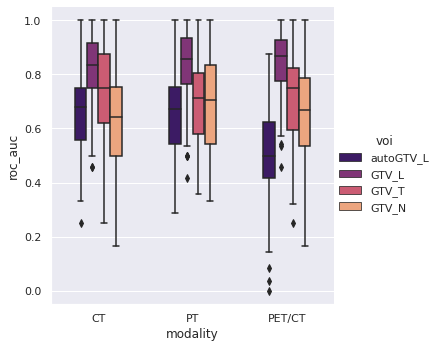

In [18]:
sns.set(rc={"figure.figsize":(18, 18)}) #width=8, height=4
ax = sns.catplot(x="modality", y="roc_auc", hue="voi", data=df, kind="box", palette="magma", width=0.5)
plt.savefig("/home/valentin/python_wkspce/plc_segmentation/reports/figures/results_ptct.png")

In [20]:
df[(df["modality"]=="PET/CT")&(df["voi"]=="GTV_L")].mean()

Unnamed: 0     149.500000
accuracy         0.781000
n_test          10.500000
n_train         94.500000
npv              0.770548
precision        0.814409
roc_auc          0.843464
sensitivity      0.845714
specificity      0.679500
split           49.500000
dtype: float64

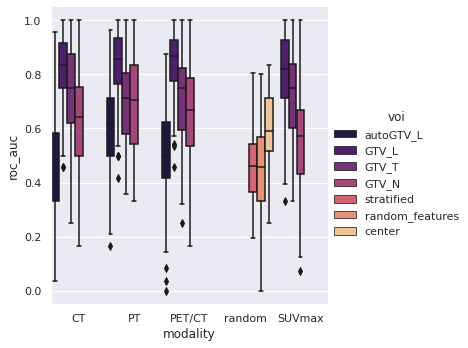

In [21]:
sns.set(rc={"figure.figsize":(8, 9)}) #width=8, height=4
ax = sns.catplot(x="modality", y="roc_auc", hue="voi", data=df_tot, kind="box", palette="magma", width=1.0)

In [22]:
df_tot[df_tot["voi"]=="random_features"].mean()

Unnamed: 0     249.500000
accuracy         0.503091
n_test          10.600000
n_train         95.400000
npv              0.303286
precision        0.581054
roc_auc          0.449869
sensitivity      0.655714
specificity      0.263500
split           49.500000
dtype: float64

In [23]:
df_tot["modality"].unique()

array(['CT', 'PT', 'PET/CT', 'random', 'SUVmax'], dtype=object)

In [24]:
df_catplot = df_tot[df_tot["modality"].isin(["CT"])]
translate_voi = {
    "GTV_L": "VOI L",
    "GTV_T": "VOI T",
    "GTV_N": "VOI N",
}
# df_catplot["voi"] = df_catplot["voi"].map(lambda x: translate_voi[x])

In [25]:
from matplotlib.markers import TICKDOWN


def significance_bar(start,
                     end,
                     height,
                     displaystring,
                     linewidth=1.2,
                     markersize=8,
                     boxpad=0.3,
                     fontsize=15,
                     color='k'):
    # draw a line with downticks at the ends
    plt.plot(
        [start, end],
        [height] * 2,
        '-',
        color=color,
        lw=linewidth,
        marker=TICKDOWN,
        markeredgewidth=linewidth,
        markersize=markersize,
        clip_on=False,
    )
    # draw the text with a bounding box covering up the line
    plt.text(0.5 * (start + end),
             height,
             displaystring,
             ha='center',
             va='center',
             bbox=dict(facecolor='1.',
                       edgecolor='none',
                       boxstyle='Square,pad=' + str(boxpad)),
             size=fontsize)


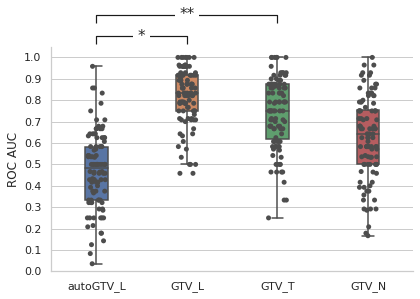

In [26]:
sns.set_style("whitegrid")
g = sns.catplot(x="voi",
                y="roc_auc",
                data=df_catplot,
                kind="box",
                fliersize=0.0,
                width=0.25,
                height=4,
                aspect=1.5)
g = sns.stripplot(x="voi", y="roc_auc", data=df_catplot, color="0.3")
g.set(ylabel='ROC AUC', xlabel='')
g.set_yticks(ticks=[0.1*k for k in range(11)])
g.set(ylim=(0.0, 1.05))
# plt.plot([1,2],[1.1,1.1], '|-k')
significance_bar(0,
                 1,
                 1.1,
                 "*",
                 linewidth=1.2,
                 markersize=8,
                 boxpad=0.3,
                 fontsize=15,
                 color='k')
significance_bar(0,
                 2,
                 1.2,
                 "**",
                 linewidth=1.2,
                 markersize=8,
                 boxpad=0.3,
                 fontsize=15,
                 color='k')
plt.savefig("petct_auc.png", dpi=200, bbox_inches="tight")

In [27]:
df_catplot = df_tot[df_tot["voi"]=="GTV_L"]
translate_modality = {
    "PT": "PET",
    "PET/CT": "PET/CT",
    "CT": "CT",
    "SUVmax": "SUV$_{max}$",
}
# df_catplot["modality"] = df_catplot["modality"].map(lambda x: translate_modality[x])

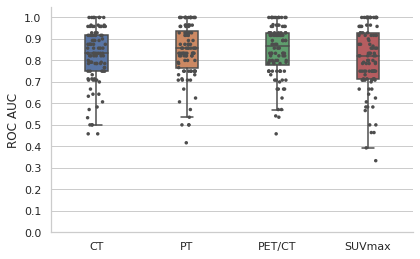

In [28]:
sns.set_style("whitegrid")
g = sns.catplot(x="modality",
                y="roc_auc",
                data=df_catplot,
                kind="box",
                fliersize=0.0,
                width=0.25,
                height=4,
                aspect=1.5)
g = sns.stripplot(x="modality", y="roc_auc", data=df_catplot, color="0.3", size=3.5)
g.set(ylabel='ROC AUC', xlabel='')
g.set_yticks(ticks=[0.1*k for k in range(11)])
g.set(ylim=(0.0, 1.05))
# plt.plot([1,2],[1.1,1.1], '|-k')

plt.savefig("gtvl_auc.png", dpi=200, bbox_inches="tight")

In [29]:
df_tot.columns

Index(['Unnamed: 0', 'accuracy', 'n_test', 'n_train', 'npv', 'precision',
       'roc_auc', 'sensitivity', 'specificity', 'split', 'modality', 'voi',
       'strategy'],
      dtype='object')

In [33]:
s1 = df_tot.loc[(df_tot["modality"]=="PET/CT") & (df_tot["voi"]=="GTV_L"), "roc_auc"].values
s2 = df_tot.loc[(df_tot["modality"]=="SUVmax") & (df_tot["voi"]=="GTV_L"), "roc_auc"].values

In [34]:
n_train = df_tot.loc[(df_tot["modality"]=="CT") & (df_tot["voi"]=="GTV_L"), "n_train"].mean()
n_test = df_tot.loc[(df_tot["modality"]=="CT") & (df_tot["voi"]=="GTV_L"), "n_test"].mean()

In [35]:
s = compare_score(s1, s2, n_train, n_test)
print(s)

{'t_stat': 0.8025980073897329, 'p_value': 0.21206483999947773, 'proba M1 > M2': 0.7150835684114809, 'proba M1 == M2': 0.1333199095929502, 'proba M1 < M2': 0.1515965219955689}


In [36]:
np.mean(s1)

0.8434642857142859

In [37]:
corrected_ci(s1, n_train, n_test)


(0.7611923214442042, 0.9257362499843675)

In [ ]:
df.columns

In [ ]:
def extract_score(modality, voi, df, score):
    return df.loc[(df["modality"] == modality) & (df_tot["voi"] == voi),
                  score].values


scores = [
    'roc_auc',
    'accuracy',
    'sensitivity',
    'specificity',
    'precision',
    'npv',
]


def print_results(modality, voi, df):
    for score in scores:
        s = extract_score(modality, voi, df, score)
        ci = corrected_ci(s, n_train, n_test)
        print(f"{score} : {np.mean(s):.4f} ({ci[0]:.4f} - {ci[1]:.4f})", )


In [ ]:
print_results("SUVmax", "GTV_N", df_tot)

In [ ]:
# s2 = df_dummy.loc[df_dummy["strategy"]=="center", "roc_auc"].values
# s2 = df_dummy.loc[df_dummy["strategy"]=="random_features", "roc_auc"].values

In [ ]:
np.mean(s2)

In [ ]:
print(s)

In [ ]:
s["p_value"] + s["proba M1 > M2"]